In [1]:
import pandas as pd
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point, box
from rtree import index
import numpy as np
from tqdm import tqdm

gdb_path = "SIM3292_geodatabase.gdb"

# 加载数据为GeoDataFrame
gdf = gpd.read_file(gdb_path, layer='SIM3292_Global_Geology')
sindex = gdf.sindex
# 获取投影参数，并打印
src_proj = gdf.crs
print(src_proj)



def transform_coords_bulk_with_pyproj(lons, lats, src_proj, dest_proj):
    transformer = Transformer.from_crs(src_proj, dest_proj, always_xy=True)
    new_x, new_y = transformer.transform(lons, lats)
    return new_x, new_y


def extract_units_from_optimized_gdb_single(x_coords, y_coords):
    # 使用预先创建的sindex
    global sindex
    units = []

    for x, y in zip(x_coords, y_coords):
        point = Point(x, y)
        possible_matches_index = list(sindex.intersection(point.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        precise_match = possible_matches[possible_matches.intersects(point)]

        if not precise_match.empty:
            units.append(precise_match.iloc[0]['Unit'])
        else:
            units.append(None)
    return units

PROJCS["Robinson_clon0_Mars_2000_Sphere",GEOGCS["GCS_Mars_2000_Sphere",DATUM["<custom>",SPHEROID["<custom>",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [15]:

def generate_global_units_grid(src_proj, dest_proj):
    global_units_grid = np.empty((1800, 3600), dtype=object)  # 180/0.1 x 360/0.1

    # 进度条
    total_blocks = (180 // 3) * (360 // 3)
    pbar = tqdm(total=total_blocks, desc="Processing global grid")

    for i in range(-180, 180, 3):
        for j in range(90, -90, -3):
            # 获取当前小块范围的坐标网格
            lon_range = np.arange(i, i + 3, 0.1)
            lat_range = np.arange(j, j - 3, -0.1)
            lons, lats = np.meshgrid(lon_range, lat_range)

            # 坐标转换
            new_x, new_y = transform_coords_bulk_with_pyproj(lons.flatten(), lats.flatten(), src_proj, dest_proj)

            # 获取units
            sub_units = extract_units_from_optimized_gdb_single(new_x, new_y)

            # 存储到全球units网格中
            x_start_idx = int((i + 180) * 10)
            y_start_idx = int((90 - j) * 10)
            global_units_grid[y_start_idx:y_start_idx + 30, x_start_idx:x_start_idx + 30] = np.array(sub_units).reshape(
                30, 30)

            pbar.update(1)

    pbar.close()
    return global_units_grid

In [16]:
from pyproj import CRS
import fiona

gdb_path = "SIM3292_geodatabase.gdb"

with fiona.open(gdb_path, layer='SIM3292_Global_Geology') as src:
    dest_proj = CRS(src.crs)
    print(dest_proj.to_string())
from method.mola.mola import get_projection

src_proj = get_projection()
src_proj = CRS(src_proj)
print(src_proj.to_string())

PROJCS["Robinson_clon0_Mars_2000_Sphere",GEOGCS["GCS_Mars_2000_Sphere",DATUM["<custom>",SPHEROID["<custom>",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_Sphere",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


In [1]:
global_grid = generate_global_units_grid(src_proj, dest_proj)
# 保存为npy文件
np.save("global_units_grid.npy", global_grid, allow_pickle=True)

NameError: name 'generate_global_units_grid' is not defined

### 处理

In [1]:
import numpy as np

global_grid = np.load("data/global_units_grid.npy", allow_pickle=True)

In [2]:
global_grid[global_grid == None] = "None"

In [3]:
unit_list = np.unique(global_grid)
unit_list

array(['AHi', 'AHtu', 'AHv', 'ANa', 'Aa', 'Ap', 'Apu', 'Av', 'Ave', 'HNb',
       'HNhu', 'HNt', 'Hp', 'Hpe', 'Hpu', 'Ht', 'Hto', 'Htu', 'Hve',
       'Nhe', 'Nhu', 'None', 'Nve', 'eAb', 'eHb', 'eHh', 'eHt', 'eHv',
       'eNh', 'eNhm', 'lAa', 'lApc', 'lApd', 'lAv', 'lAvf', 'lHb', 'lHl',
       'lHt', 'lHv', 'lHvf', 'lNh', 'lNv', 'mAl', 'mNh', 'mNhm'],
      dtype=object)

In [4]:
import pandas as pd

geo_df = pd.read_excel("document/SIM3292_Global_Geology.xlsx", sheet_name=0)
# 把所有的NAN替换为"None"
geo_df = geo_df.fillna("None")
geo_df

,unit,unit_name,description,ADDITIONAL CHARACTERISTICS,interpretation,RGB,main_unit,main_unit_desc,corresponding_value
0,mAl,Middle Amazonian lowland,Hummocky to undulating; grades into fields of ...,Distributed within Vastitas Borealis and other...,Ice-rich loess. Periglacial modification forme...,"189, 192, 49",LOWLAND UNITS,Materials occupying northern lowlands (mostly ...,1
1,lHl,Late Hesperian lowland,Planar to undulating; lobate and troughed marg...,Continuous across most of the northern plains....,Fluvial/lacustrine/marine and colluvial sedi_x...,"139, 198, 62",LOWLAND UNITS,Materials occupying northern lowlands (mostly ...,2
2,AHi,Amazonian and Hesperian,Craters with rims and sur_x0002_rounding blank...,Global occurrence. Superposes Noachian units; ...,"Upturned, ejected, and brecciated target rocks...","255, 241, 1",IMPACT UNIT,None,3
3,lApc,Late Amazonian polar cap,Hummocky and pitted at meter (northern cap) to...,Thinly caps parts of Planum Boreum and Planum ...,Residual ice (H2O in northern cap and mainly C...,"217, 241, 251",POLAR UNITS,"Mostly ice, dust, and other fines at polar lat...",4
4,lApd,Late Amazonian polar dunes,"Mounds with barchan-like, linear, and other du...","Surrounds Planum Boreum. Superposes units mAl,...",Wind-blown sand organized into variety of dune...,"254, 233, 186",POLAR UNITS,"Mostly ice, dust, and other fines at polar lat...",5
5,Apu,Amazonian polar undivided,Plateaus hundreds of kilometers across at both...,Forms Planum Australe and upper part of Planum...,Water ice with minor amounts of dust inter_x00...,"155, 180, 189",POLAR UNITS,"Mostly ice, dust, and other fines at polar lat...",6
6,Ap,Amazonian polar,Plains_x0002_forming deposit. Relatively low r...,"Occurs in vicinity of Cavi Angusti, near Planu...",Dominantly water ice and minor lithic fines; p...,"0, 155, 202",POLAR UNITS,"Mostly ice, dust, and other fines at polar lat...",7
7,Hp,Hesperian polar,Plains-forming deposits marked by narrow sinuo...,Surrounds Planum Australe. Superposes units lN...,Water-ice sheets as indicated by dielectric co...,"0, 135, 165",POLAR UNITS,"Mostly ice, dust, and other fines at polar lat...",8
8,Hpu,Plateau-forming deposits. Decameter-thick laye...,Plateau-forming deposits. Decameter-thick laye...,"Forms base of main lobe of Planum Boreum, incl...",Roughly equal proportions of water ice and lit...,"111, 152, 165",POLAR UNITS,"Mostly ice, dust, and other fines at polar lat...",9
9,Hpe,Hesperian polar edifice,Shields and cones having summit and flank depr...,Forms Scandia Tholi and Sisyphi Tholus. Gradat...,Cryovolcanic or sedimentary or igneous vol_x00...,"0, 114, 188",POLAR UNITS,"Mostly ice, dust, and other fines at polar lat...",10


In [5]:
# unit_list中的所有值是否在geo_df['unit']中
for unit in unit_list:
    if unit not in geo_df['unit'].values:
        print(unit)

In [6]:
# 遍历geo_df，把unit和对应的RGB值组成字典
unit_rgb_dict = {}
for i in range(len(geo_df)):
    unit = geo_df.iloc[i]['unit']
    # 拆分RGB值，逗号分隔，转换为int
    r, g, b = geo_df.iloc[i]['RGB'].split(",")
    r, g, b = int(r), int(g), int(b)
    unit_rgb_dict[unit] = (r, g, b)
unit_rgb_dict

{'mAl': (189, 192, 49),
 'lHl': (139, 198, 62),
 'AHi': (255, 241, 1),
 'lApc': (217, 241, 251),
 'lApd': (254, 233, 186),
 'Apu': (155, 180, 189),
 'Ap': (0, 155, 202),
 'Hp': (0, 135, 165),
 'Hpu': (111, 152, 165),
 'Hpe': (0, 114, 188),
 'eAb': (152, 212, 192),
 'lHb': (159, 179, 158),
 'eHb': (85, 147, 151),
 'HNb': (115, 151, 136),
 'lAv': (249, 190, 183),
 'lAvf': (205, 176, 166),
 'Av': (248, 170, 157),
 'AHv': (247, 150, 107),
 'lHv': (201, 124, 154),
 'lHvf': (203, 158, 143),
 'eHv': (178, 121, 180),
 'lNv': (135, 129, 189),
 'Ave': (204, 124, 89),
 'Hve': (243, 110, 33),
 'Nve': (200, 36, 43),
 'lAa': (254, 215, 2),
 'Aa': (238, 209, 19),
 'ANa': (187, 165, 50),
 'AHtu': (233, 227, 216),
 'Htu': (219, 212, 209),
 'lHt': (254, 202, 10),
 'eHt': (224, 175, 36),
 'Ht': (254, 221, 163),
 'Hto': (170, 224, 249),
 'HNt': (249, 165, 27),
 'HNhu': (202, 194, 191),
 'Nhu': (181, 169, 165),
 'eHh': (233, 202, 175),
 'lNh': (206, 174, 135),
 'mNh': (204, 157, 128),
 'eNh': (185, 135, 95

In [7]:
# unit 和 corresponding_value 的对应关系，组成字典
unit_corresponding_value_dict = {}
for i in range(len(geo_df)):
    unit = geo_df.iloc[i]['unit']
    corresponding_value = geo_df.iloc[i]['corresponding_value']
    unit_corresponding_value_dict[unit] = corresponding_value
unit_corresponding_value_dict

{'mAl': 1,
 'lHl': 2,
 'AHi': 3,
 'lApc': 4,
 'lApd': 5,
 'Apu': 6,
 'Ap': 7,
 'Hp': 8,
 'Hpu': 9,
 'Hpe': 10,
 'eAb': 11,
 'lHb': 12,
 'eHb': 13,
 'HNb': 14,
 'lAv': 15,
 'lAvf': 16,
 'Av': 17,
 'AHv': 18,
 'lHv': 19,
 'lHvf': 20,
 'eHv': 21,
 'lNv': 22,
 'Ave': 23,
 'Hve': 24,
 'Nve': 25,
 'lAa': 26,
 'Aa': 27,
 'ANa': 28,
 'AHtu': 29,
 'Htu': 30,
 'lHt': 31,
 'eHt': 32,
 'Ht': 33,
 'Hto': 34,
 'HNt': 35,
 'HNhu': 36,
 'Nhu': 37,
 'eHh': 38,
 'lNh': 39,
 'mNh': 40,
 'eNh': 41,
 'Nhe': 42,
 'mNhm': 43,
 'eNhm': 44,
 'None': 45}

In [8]:
# 把global_grid中的unit替换为对应的RGB值
global_grid_rgb = np.empty((1800, 3600, 3), dtype=np.uint8)
from tqdm import tqdm

pbar = tqdm(total=1800 * 3600, desc="Processing global grid")
for i in range(1800):
    for j in range(3600):
        unit = global_grid[i, j]
        global_grid_rgb[i, j] = unit_rgb_dict[unit]
        pbar.update(1)
pbar.close()

Processing global grid: 100%|██████████| 6480000/6480000 [00:06<00:00, 1057039.33it/s]


In [15]:
np.arange(0, 3600 + 600, 600)

array([   0,  600, 1200, 1800, 2400, 3000, 3600])

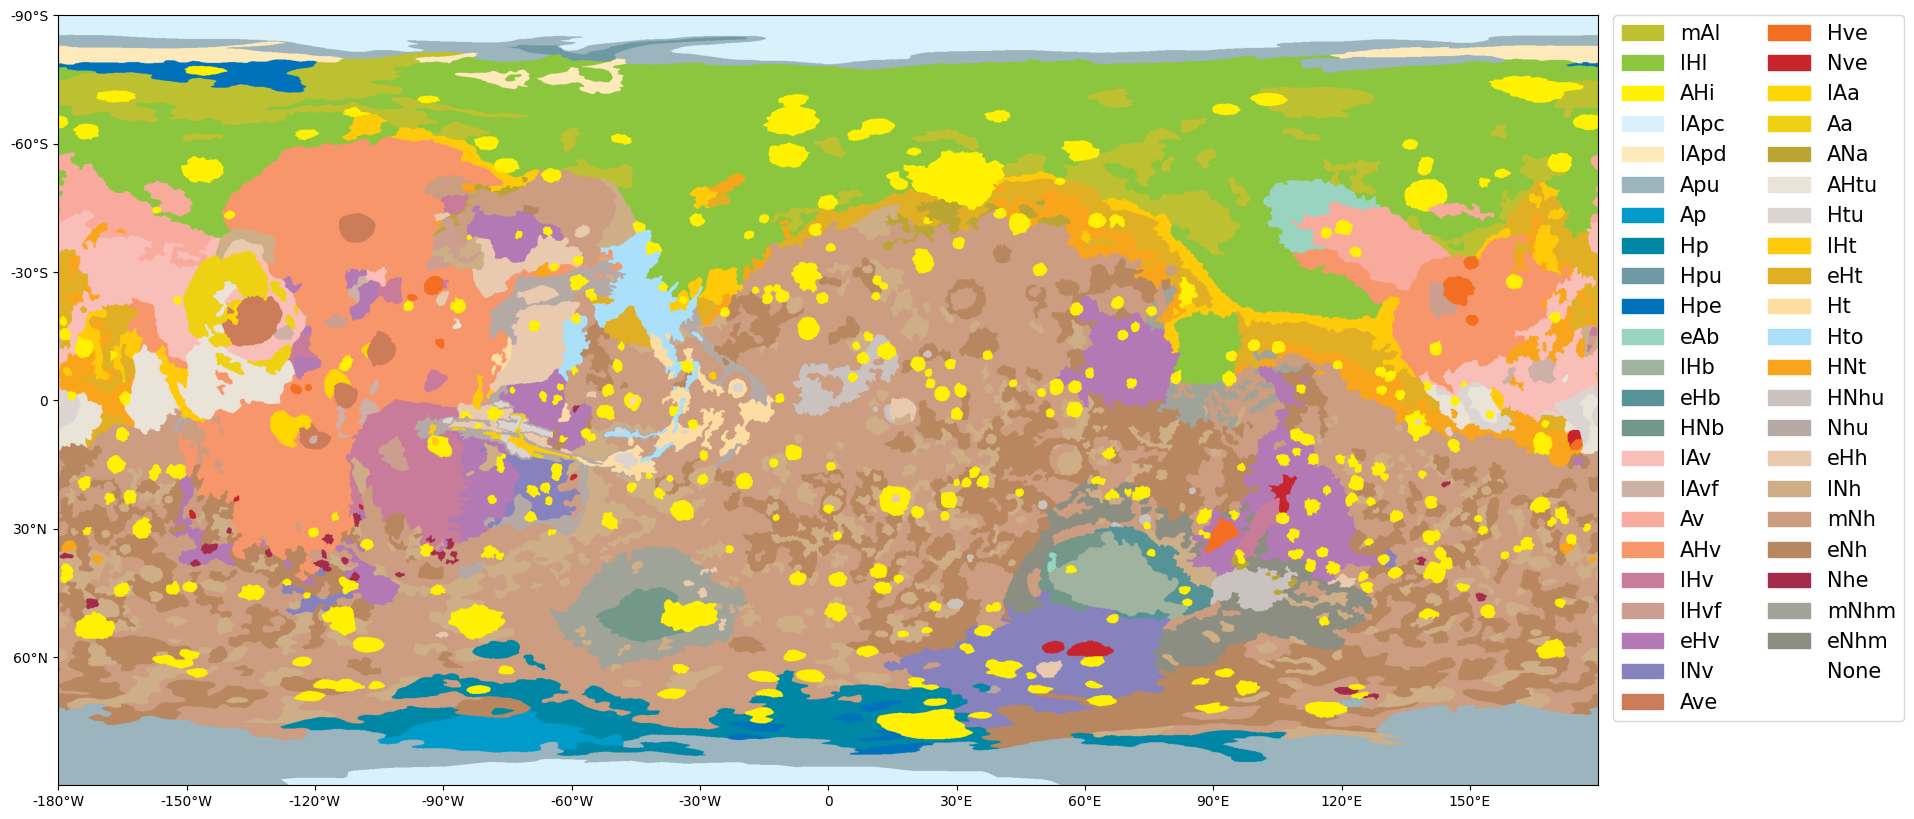

In [44]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 根据RGB值绘制全球地质图
fig, ax = plt.subplots(figsize=(20, 10))
# 设置坐标轴刻度，-180~180，-90~90，30度一个刻度，即间隔300个像素
ax.set_xticks(np.arange(0, 3600 + 300, 300))
ax.set_yticks(np.arange(0, 1800 + 300, 300))
# 设置坐标轴刻度标签，如果精度小于0，后面加上°W，如果精度大于0，后面加上°E，如果等于0，不加
ax.set_xticklabels([f"{i}°W" if i < 0 else f"{i}°E" if i > 0 else f"{i}" for i in range(-180, 180 + 30, 30)])
ax.set_yticklabels([f"{i}°S" if i < 0 else f"{i}°N" if i > 0 else f"{i}" for i in range(-90, 90 + 30, 30)])
# 画图
ax.imshow(global_grid_rgb)
# 创建标签列表，每个地质单元的标签
legend_labels = [unit for unit in unit_rgb_dict]

# 创建一个包含色块和unit字符串的图例项列表
legend_handles = []
for unit, rgb in unit_rgb_dict.items():
    # 创建一个色块 (Patch)
    color_patch = Patch(color=(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255), label=unit)
    legend_handles.append(color_patch)

# 添加图例到图的右边，分为两列
ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
          ncol=2, fontsize=15)

# 显示图
plt.show()
fig.savefig("data/global_geology.png", dpi=300, bbox_inches='tight')